# Quickstart

In [1]:
import os

# uncomment to disable NVIDIA GPUs
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
# or pick the device (cpu, gpu, and tpu)
#os.environ['JAX_PLATFORMS'] = 'cpu'

# change JAX GPU memory preallocation fraction
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'

# you do not want this
#os.environ['XLA_FLAGS'] = '--xla_gpu_deterministic_ops=true'

%matplotlib inline
%load_ext autoreload 
%autoreload 2

import jax
from jax import random as jr, numpy as jnp, jit
from functools import partial
#jax.print_environment_info()

!nvidia-smi --query-gpu=gpu_name --format=csv,noheader

NVIDIA A100-PCIE-40GB


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [2]:
import matplotlib.pyplot as plt

from pmwd import (
    Configuration,
    Cosmology, SimpleLCDM,
    boltzmann, linear_power, growth,
    white_noise, linear_modes,
    lpt,
    nbody,
    scatter,
)
from pmwd.pm_util import fftinv
from pmwd.spec_util import powspec
from pmwd.vis_util import simshow

# Simply

In [3]:
def run(mesh_length):
    ptcl_spacing = 640 / mesh_length 
    ptcl_grid_shape = (mesh_length,) * 3

    conf = Configuration(ptcl_spacing, ptcl_grid_shape, mesh_shape=1, a_start=0.1, lpt_order=1)
    cosmo = Cosmology(conf, A_s_1e9=2.105, n_s=0.9665, Omega_m=0.3111, Omega_b=0.0490, h=0.6766)
    cosmo = boltzmann(cosmo, conf)

    seed = 0
    modes = white_noise(seed, conf)
    modes = linear_modes(modes, cosmo, conf)
    ptcl, obsvbl = lpt(modes, cosmo, conf)
    ptcl, obsvbl = nbody(ptcl, obsvbl, cosmo, conf)
    dens = scatter(ptcl, conf)

    dens_lin = fftinv(modes, shape=conf.ptcl_grid_shape, norm=conf.ptcl_spacing)
    dens_lin *= growth(conf.a_stop, cosmo, conf)
    return dens, dens_lin, conf

In [4]:
denses = []
sizes = [64,128,256]
for s in sizes:
    dens, dl, conf = run(s)
    denses.append([dens, dl, conf])

jrun = jit(partial(run, 256))

2024-12-08 12:41:03.613453: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [5]:
%%time
from jax import block_until_ready
res = block_until_ready(jrun())

CPU times: user 37.1 s, sys: 519 ms, total: 37.6 s
Wall time: 37.8 s


In [6]:
%%time
from jax import block_until_ready
res = block_until_ready(jrun())

CPU times: user 141 ms, sys: 84.4 ms, total: 226 ms
Wall time: 1.09 s


In [7]:
from jax_cosmo import Cosmology as Cosmo, background
import jax_cosmo as jc

from jax.experimental.ode import odeint
from jaxpm.painting import cic_paint
from jaxpm.pm import linear_field
from montecosmo.bricks import lpt as mylpt, get_ode_fn, make_ode_fn
from diffrax import diffeqsolve, ODETerm, SaveAt, PIDController, Euler, Heun, Dopri5


# Planck 2018 paper VI Table 2 final column (best fit)
Planck18 = partial(Cosmo,
    # Omega_m = 0.3111
    Omega_c=0.2607,
    Omega_b=0.0490,
    Omega_k=0.0,
    h=0.6766,
    n_s=0.9665,
    sigma8=0.8102,
    w0=-1.0,
    wa=0.0,)

def nbody_diffrax(cosmo:Cosmology, mesh_shape, particles, a_lpt, a_obs, 
          grad_fd, lap_fd, trace_meshes=2, tol=1e-5):
    terms = ODETerm(get_ode_fn(cosmo, mesh_shape, grad_fd, lap_fd))
    solver = Dopri5()
    controller = PIDController(rtol=tol, atol=tol, pcoeff=0.4, icoeff=1, dcoeff=0)
    if trace_meshes < 2: 
        saveat = SaveAt(t1=True)
    else: 
        saveat = SaveAt(ts=jnp.linspace(a_lpt, a_obs, trace_meshes))      
    sol = diffeqsolve(terms, solver, a_lpt, a_obs, dt0=None, y0=particles,
                            stepsize_controller=controller, max_steps=100, saveat=saveat)
    particles = sol.ys
    # debug.print("n_solvsteps: {n}", n=sol.stats['num_steps'])
    return particles

def nbody_odeint(cosmo:Cosmology, mesh_shape, particles, a_lpt, a_obs, 
          grad_fd, lap_fd, trace_meshes=2, tol=1e-5):
    ode_fn = make_ode_fn(mesh_shape, grad_fd, lap_fd)
    return odeint(ode_fn, particles, 
                     jnp.linspace(a_lpt, a_obs, 2), cosmo, rtol=tol, atol=tol)

def run_jpm(mesh_length, a_lpt=0.1, a_obs=1., lpt_order=1, grad_fd=True, lap_fd=False, tol=1e-5):
    # Initial power spectrum
    mesh_shape = (mesh_length,) * 3
    box_size = jnp.ones(3) * 640
    cosmo = Planck18()
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(cosmo, k)
    pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # JaxPM init to FastPM init
    init_mesh = linear_field(mesh_shape, box_size, pk_fn, seed=jr.key(0)) # XXX

    x_part = jnp.indices(mesh_shape).reshape(3,-1).T
    cosmo._workspace = {}  # FIX ME: this a temporary fix
    dx, p_part, f = mylpt(cosmo, init_mesh, x_part, a_lpt, lpt_order, grad_fd, lap_fd)

    if a_obs == a_lpt:
        pos = x_part + dx
    else:
        res = nbody_diffrax(cosmo, mesh_shape, jnp.stack([x_part + dx, p_part]), a_lpt, a_obs, 
                    grad_fd, lap_fd, trace_meshes=2, tol=tol)  
        pos, p = res[-1]

    return cic_paint(jnp.zeros(mesh_shape), pos), init_mesh, box_size

In [8]:
denses_jpm = []
sizes = [64,128,256]
for s in sizes:
    dens, dl, conf = run_jpm(s)
    denses_jpm.append([dens, dl, conf])

jpmrun = jit(partial(run_jpm, 256))

In [9]:
%%time
from jax import block_until_ready
res = block_until_ready(jpmrun())

CPU times: user 6.59 s, sys: 134 ms, total: 6.72 s
Wall time: 7.18 s


In [10]:
%%time
from jax import block_until_ready
res = block_until_ready(jpmrun())

CPU times: user 2.09 s, sys: 0 ns, total: 2.09 s
Wall time: 2.09 s


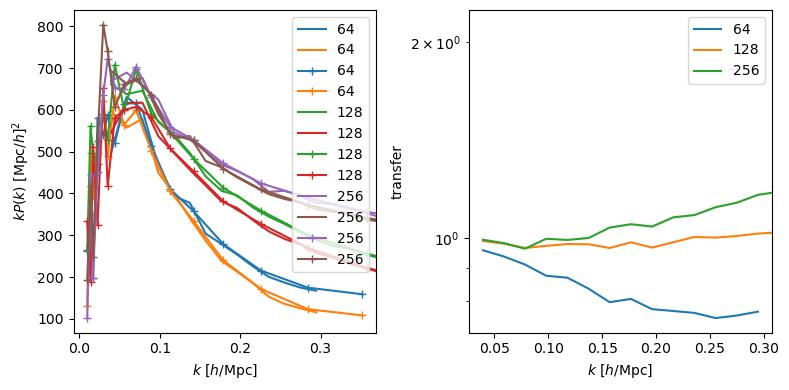

(None, None)

In [19]:
from montecosmo.metrics import power_spectrum
from jaxpm.painting import compensate_cic
from montecosmo.plot import plot_pk, plot_trans

plt.figure(figsize=(8,4))
i_color = 0
plt.subplot(121)
for dens, dens_jpm, lab in zip(denses, denses_jpm, sizes):
    dens, dl, conf = dens
    dens_jpm, dl_jpm, conf_jpm = dens_jpm
    deconv = 4
    ks, pk = power_spectrum(compensate_cic(dens), box_size=conf_jpm)
    # ks, pk_lin = power_spectrum(dl, box_size=3*(640.,))
    k, P, _, _ = powspec(dens, conf.cell_size, deconv=deconv)

    ksjpm, pkjpm = power_spectrum(compensate_cic(dens_jpm), box_size=conf_jpm)
    kjpm, Pjpm, _, _ = powspec(dens_jpm, conf.cell_size, deconv=deconv)

    log = False
    plot_pk(ks, pk, f'C{i_color}-', log=log, label=lab)
    plot_pk(ksjpm, pkjpm, f'C{i_color+1}-', log=log, label=lab)
    plot_pk(k, P, f'C{i_color}+-', log=log, label=lab)
    plot_pk(kjpm, Pjpm, f'C{i_color+1}+-', log=log, label=lab)

    # plot_pk(ks, pk_lin, ':k', label='lin')
    plt.xlim(*plt.xlim())
    i_color += 2

plt.legend()

plt.subplot(122)
for dens, lab in zip(denses, [64,128,256]):
    ks, pk = power_spectrum(compensate_cic(dens[0]), box_size=3*(640.,))
    ks, pk_lin = power_spectrum(dens[1], box_size=3*(640.,))
    plot_trans(ks, (pk/pk_lin)**.5, label=lab)
    plt.xlim(*plt.xlim())

plt.legend()
plt.tight_layout(), plt.show()

## Simulate Forward

`Configuration` stores static configuration and parameters for which we do not need derivatives.

In [20]:
if jax.default_backend() == 'gpu':
    ptcl_spacing = 1.  # Lagrangian space Cartesian particle grid spacing, in Mpc/h by default
    ptcl_grid_shape = (256,) * 3
else:
    ptcl_spacing = 4.
    ptcl_grid_shape = (64,) * 3

conf = Configuration(ptcl_spacing, ptcl_grid_shape, mesh_shape=2)  # 2x mesh shape

In [21]:
print(conf)  # with other default parameters
print(f'Simulating {conf.ptcl_num} particles with a {conf.mesh_shape} mesh for {conf.a_nbody_num} time steps.')

Configuration(ptcl_spacing=1.0,
              ptcl_grid_shape=(256, 256, 256),
              mesh_shape=(512, 512, 512),
              cosmo_dtype=dtype('float64'),
              pmid_dtype=dtype('int16'),
              float_dtype=dtype('float32'),
              k_pivot_Mpc=0.05,
              T_cmb=2.7255,
              M=1.98847e+40,
              L=3.0856775815e+22,
              T=3.0856775815e+17,
              transfer_fit=True,
              transfer_fit_nowiggle=False,
              transfer_lgk_min=-4,
              transfer_lgk_max=3,
              transfer_lgk_maxstep=0.0078125,
              growth_rtol=1.4901161193847656e-08,
              growth_atol=1.4901161193847656e-08,
              growth_inistep=(1, None),
              lpt_order=2,
              a_start=0.015625,
              a_stop=1,
              a_lpt_maxstep=0.0078125,
              a_nbody_maxstep=0.015625,
              symp_splits=((0, 0.5), (1, 0.5)),
              chunk_size=16777216)
Simulating 167772

`Cosmology` stores interesting parameters, whose derivatives we need.

In [22]:
cosmo = Cosmology(conf, A_s_1e9=2.0, n_s=0.96, Omega_m=0.3, Omega_b=0.05, h=0.7)
# or simply use the predefined SimpleLCDM
#cosmo = SimpleLCDM(conf)

print(cosmo)

Cosmology(A_s_1e9=Array(2., dtype=float64),
          n_s=Array(0.96, dtype=float64),
          Omega_m=Array(0.3, dtype=float64),
          Omega_b=Array(0.05, dtype=float64),
          h=Array(0.7, dtype=float64),
          Omega_k_=None,
          w_0_=None,
          w_a_=None,
          transfer=None,
          growth=None,
          varlin=None)


``boltzmann`` computes the transfer and growth functions and caches them in ``Cosmology``.

The first run is slower because it includes the **JIT compilation** time. JAX uses **asynchronous dispatch** to hide Python overheads. To measure the true cost, use ``jax.block_until_ready()`` to wait for the computation to complete.

In [23]:
%time cosmo = jax.block_until_ready(boltzmann(cosmo, conf))
%timeit jax.block_until_ready(boltzmann(cosmo, conf))

CPU times: user 1.19 s, sys: 26.2 ms, total: 1.22 s
Wall time: 1.58 s
19.7 ms ± 314 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Generate a white noise field, and scale it with the linear power spectrum:

In [24]:
seed = 0
modes = white_noise(seed, conf)

modes = linear_modes(modes, cosmo, conf)

Solve LPT at some early time:

In [25]:
%time ptcl, obsvbl = jax.block_until_ready(lpt(modes, cosmo, conf))
%timeit jax.block_until_ready(lpt(modes, cosmo, conf))
ptcl.disp.std(), ptcl.vel.std()

CPU times: user 945 ms, sys: 8.87 ms, total: 954 ms
Wall time: 1.04 s
14.6 ms ± 34.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


(Array(0.105, dtype=float32), Array(0.007, dtype=float32))

Finally, N-body time integration from the LPT initial conditions:

In [26]:
%time jax.block_until_ready(nbody(ptcl, obsvbl, cosmo, conf))
%time ptcl, obsvbl = jax.block_until_ready(nbody(ptcl, obsvbl, cosmo, conf))
ptcl.disp.std(), ptcl.vel.std()

CPU times: user 2.94 s, sys: 915 ms, total: 3.85 s
Wall time: 4.3 s
CPU times: user 882 ms, sys: 816 ms, total: 1.7 s
Wall time: 1.97 s


(Array(5.318, dtype=float32), Array(3.286, dtype=float32))

Scatter the particles to mesh to get the density field, and plot a slab's 2D projection:

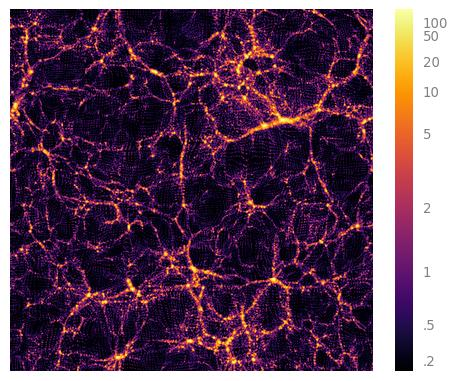

In [27]:
dens = scatter(ptcl, conf)
simshow(dens[:16].mean(axis=0), norm='CosmicWebNorm');

Measure and plot the matter density power spectra:

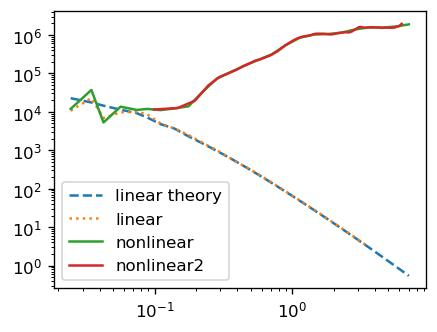

In [37]:
from montecosmo.metrics import power_spectrum
k, P, _, _ = powspec(dens, conf.cell_size)
ks, pk = power_spectrum(dens, box_size=jnp.array(dens.shape)*conf.cell_size)

dens_lin = fftinv(modes, shape=conf.ptcl_grid_shape, norm=conf.ptcl_spacing)
dens_lin *= growth(conf.a_stop, cosmo, conf)
k_lin, P_lin, _, _ = powspec(dens_lin, conf.ptcl_spacing)

P_linth = linear_power(k, conf.a_stop, cosmo, conf)

plt.figure(figsize=(4, 3), dpi=120)
plt.loglog(k, P_linth, ls='--', label='linear theory')
plt.loglog(k_lin, P_lin, ls=':', label='linear')
plt.loglog(k, P, ls='-', label='nonlinear')
plt.loglog(ks, pk, ls='-', label='nonlinear2')
plt.legend();

We can combine all steps together:

In [12]:
cosmo = SimpleLCDM(conf)
modes = white_noise(seed, conf)

def model(modes, cosmo, conf):
    cosmo = boltzmann(cosmo, conf)
    modes = linear_modes(modes, cosmo, conf)
    ptcl, obsvbl = lpt(modes, cosmo, conf)
    ptcl, obsvbl = nbody(ptcl, obsvbl, cosmo, conf)
    return ptcl, obsvbl

print(f'Simulating {conf.ptcl_num} particles with a {conf.mesh_shape} mesh for {conf.a_nbody_num} time steps.')
%time jax.block_until_ready(model(modes, cosmo, conf));

Simulating 16777216 particles with a (512, 512, 512) mesh for 63 time steps.
CPU times: user 711 ms, sys: 545 ms, total: 1.26 s
Wall time: 1.43 s


## Simulate Forward and Differentiate Backward

For the gradient, we use the same ``Configuration`` and ``Cosmology`` as before, but different white noise ``modes``.

In [13]:
seed = 1  # change the seed for a different realization, to be compared to the previous one in the objective
modes = white_noise(seed, conf, real=True)  # this time we want real modes to look at their gradients

Define a simple MSE objective function between this and the previous realizations of density fields, and differentiate it with respect to the modes and cosmological parameters:

In [14]:
def obj(tgt_dens, modes, cosmo, conf):
    cosmo = boltzmann(cosmo, conf)
    modes = linear_modes(modes, cosmo, conf)
    ptcl, obsvbl = lpt(modes, cosmo, conf)
    ptcl, obsvbl = nbody(ptcl, obsvbl, cosmo, conf)
    dens = scatter(ptcl, conf)
    return (dens - tgt_dens).var()

obj_grad = jax.grad(obj, argnums=(1, 2))

print(f'Simulating {conf.ptcl_num} particles with a {conf.mesh_shape} mesh for {conf.a_nbody_num} time steps, '
      'and then differentiating backward.')
%time jax.block_until_ready(obj_grad(dens, modes, cosmo, conf))
%time modes_grad, cosmo_grad = jax.block_until_ready(obj_grad(dens, modes, cosmo, conf))

Simulating 16777216 particles with a (512, 512, 512) mesh for 63 time steps, and then differentiating backward.
CPU times: user 20.4 s, sys: 2.32 s, total: 22.7 s
Wall time: 19.3 s
CPU times: user 3.39 s, sys: 1.9 s, total: 5.29 s
Wall time: 5.27 s


A slice of the mode gradients:

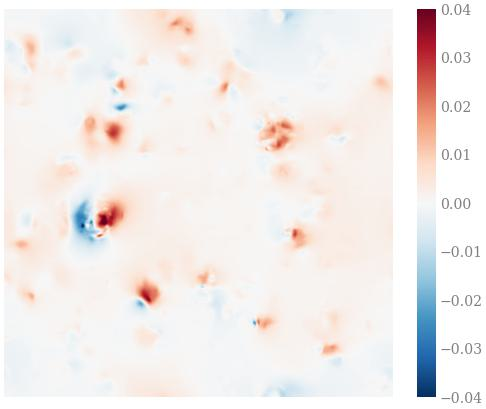

In [15]:
simshow(modes_grad[..., 0], cmap='RdBu_r', vmin=-0.04, vmax=0.04);

Cosmological parameter gradients:

In [16]:
print(cosmo_grad)

Cosmology(A_s_1e9=Array(51.601, dtype=float64),
          n_s=Array(121.798, dtype=float64),
          Omega_m=Array(569.083, dtype=float64),
          Omega_b=Array(-1422.57, dtype=float64),
          h=Array(361.472, dtype=float64),
          Omega_k_=None,
          w_0_=None,
          w_a_=None,
          transfer=None,
          growth=None,
          varlin=None)
